# WGAN-GP + Adaptive-D Hooks (BCICIV-2b GDF)
This notebook is a **research-ready template**:
- Loads **BCI Competition IV 2b** `.gdf` files from `BCICIV_2b_gdf.zip`
- Standard **WGAN-GP** training (critic + gradient penalty)
- **Adaptive Discriminator hooks** (empty) for experimentation
- **History logging**, **checkpoint saving**, **best checkpoint saving**, and **resume support**
- **Training curve plots**


In [3]:
# Run this once (for google colab)
# !mkdir -p data/BCICIV_2b_gdf
# !mv *.gdf data/BCICIV_2b_gdf/

In [4]:
# Cell 1 — Install deps (Colab-friendly)
# If you already installed these, you can skip this cell. 
# %pip -q install mne numpy scipy


In [1]:
# Cell 2 — Imports & Reproducibility
import os
import random
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Device:", DEVICE)

# Optional: reduce common numba-related surprises with some MNE setups
os.environ["NUMBA_DISABLE_JIT"] = "1"


Device: cuda


In [2]:
from pathlib import Path

DATA_DIR = Path("./BCICIV_2b_gdf")

gdf_files = list(DATA_DIR.glob("*.gdf"))
print("Number of .gdf files:", len(gdf_files))

Number of .gdf files: 45


In [3]:
# Cell 3 — Dataset path check (NO unzip)
from pathlib import Path

DATA_DIR = Path("./BCICIV_2b_gdf")

if not DATA_DIR.exists():
    raise FileNotFoundError(
        "DATA_DIR not found. Upload the extracted 'BCICIV_2b_gdf/' folder to ./data/"
    )

print("Using dataset directory:", DATA_DIR.resolve())
print("Found GDF files:", len(list(DATA_DIR.rglob("*.gdf"))))

Using dataset directory: /home/glider/gans_eeg/gradient_norm/BCICIV_2b_gdf
Found GDF files: 45


In [4]:
# Cell 4 — Load BCICIV-2b (GDF -> epochs -> tensors) [FIXED: use annotation labels]
import mne
import numpy as np
from pathlib import Path
from typing import Dict, Optional, Tuple

def _find_gdf_files(root: Path) -> list:
    return sorted([p for p in root.rglob("*.gdf")])

def load_bciciv2b_epochs_by_labels(
    root: Path,
    file_glob: str = "*T.gdf",
    tmin: float = 0.0,
    tmax: float = 4.0,
    resample_hz: int = 256,
    picks: str = "eeg",
    baseline: Optional[Tuple[float, float]] = None,
    wanted_labels: Tuple[str, str] = ("769", "770"),  # left/right in BCICIV
    verbose: bool = True,
) -> Tuple[np.ndarray, np.ndarray, int, Dict[str, int]]:
    all_files = _find_gdf_files(root)
    if file_glob:
        import fnmatch
        all_files = [f for f in all_files if fnmatch.fnmatch(f.name, file_glob)]

    if len(all_files) == 0:
        raise FileNotFoundError(f"No .gdf files found under {root} (file_glob={file_glob})")

    X_list, y_list = [], []
    last_sfreq = None

    # Fixed class order: wanted_labels[0] -> class 0, wanted_labels[1] -> class 1
    global_event_ids = {"left": wanted_labels[0], "right": wanted_labels[1]}

    for gdf_path in all_files:
        print("\n=== Reading:", gdf_path.name, "===")

        raw = mne.io.read_raw_gdf(str(gdf_path), preload=True, verbose="ERROR")
        raw.pick(picks)
        raw.resample(resample_hz)

        events, event_dict = mne.events_from_annotations(raw, verbose="ERROR")
        if verbose:
            print("Available annotation events:", event_dict)

        # Convert wanted annotation labels -> internal event codes for THIS file
        missing = [lab for lab in wanted_labels if lab not in event_dict]
        if len(missing) > 0:
            print(f"Skipping {gdf_path.name} (missing labels {missing})")
            continue

        event_id = {"left": event_dict[wanted_labels[0]], "right": event_dict[wanted_labels[1]]}
        print("Using internal event codes:", event_id, "(for labels", wanted_labels, ")")

        epochs = mne.Epochs(
            raw,
            events=events,
            event_id=event_id,
            tmin=tmin,
            tmax=tmax,
            baseline=baseline,
            preload=True,
            reject=None,
            on_missing="warn",
            verbose="ERROR",
        )

        if len(epochs) == 0:
            print(f"No epochs created for {gdf_path.name}. Skipping.")
            continue

        data = epochs.get_data().astype(np.float32)  # (N, C, L)
        labels = epochs.events[:, -1]  # internal codes (e.g., 4/5)

        # Map internal codes to 0/1 consistently using event_id dict
        code_to_idx = {int(event_id["left"]): 0, int(event_id["right"]): 1}
        y = np.array([code_to_idx[int(c)] for c in labels], dtype=np.int64)

        X_list.append(data)
        y_list.append(y)
        last_sfreq = int(raw.info["sfreq"])

    if len(X_list) == 0:
        raise RuntimeError(
            "No epochs were created from any file. "
            "Double-check dataset contents and wanted_labels."
        )

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y, last_sfreq, global_event_ids


# =========================
# NEW: Load unlabeled windows from E files (for evaluation only)
# =========================
def load_bciciv2b_unlabeled_windows(
    root: Path,
    file_glob: str = "*E.gdf",
    window_sec: float = 4.0,
    stride_sec: float = 4.0,
    resample_hz: int = 256,
    picks: str = "eeg",
    verbose: bool = True,
) -> Tuple[np.ndarray, int]:
    import fnmatch

    all_files = _find_gdf_files(root)
    if file_glob:
        all_files = [f for f in all_files if fnmatch.fnmatch(f.name, file_glob)]

    if len(all_files) == 0:
        raise FileNotFoundError(f"No .gdf files found under {root} (file_glob={file_glob})")

    X_list = []
    last_sfreq = None

    for gdf_path in all_files:
        if verbose:
            print("\n=== Reading (E unlabeled):", gdf_path.name, "===")

        raw = mne.io.read_raw_gdf(str(gdf_path), preload=True, verbose="ERROR")
        raw.pick(picks)
        raw.resample(resample_hz)

        sfreq = int(raw.info["sfreq"])
        last_sfreq = sfreq

        data = raw.get_data().astype(np.float32)  # (C, T)
        L = int(window_sec * sfreq)
        stride = int(stride_sec * sfreq)

        # slide fixed windows
        for start in range(0, data.shape[1] - L + 1, stride):
            seg = data[:, start:start + L]  # (C, L)
            X_list.append(seg)

    X = np.stack(X_list, axis=0)  # (N, C, L)
    return X, last_sfreq


# ---- Configure epoching (T) ----
RESAMPLE_HZ = 256
TMIN, TMAX = 0.0, 4.0
FILE_GLOB = "*T.gdf"  # training runs

X_np, y_np, sfreq, USED_LABELS = load_bciciv2b_epochs_by_labels(
    root=DATA_DIR,
    file_glob=FILE_GLOB,
    tmin=TMIN,
    tmax=TMAX,
    resample_hz=RESAMPLE_HZ,
    picks="eeg",
    baseline=None,
    wanted_labels=("769", "770"),
    verbose=True,
)

# Fix SEQ_LEN to be divisible by 16 (crop the last sample if needed)
SEQ_LEN = X_np.shape[2]
if SEQ_LEN % 16 != 0:
    new_len = (SEQ_LEN // 16) * 16
    print(f"Cropping SEQ_LEN from {SEQ_LEN} -> {new_len} to satisfy architecture constraint.")
    X_np = X_np[:, :, :new_len]

CHANNELS = X_np.shape[1]
SEQ_LEN  = X_np.shape[2]
print("CHANNELS:", CHANNELS, "SEQ_LEN:", SEQ_LEN)
assert SEQ_LEN % 16 == 0


# =========================
# NEW: Build + save Real Evaluation (E) windows in the SAME space as T
# (No training on E. This is for generate-compare evaluation only.)
# =========================
X_eval_E, sfreq_E = load_bciciv2b_unlabeled_windows(
    root=DATA_DIR,
    file_glob="*E.gdf",
    window_sec=(TMAX - TMIN),      # 4.0 sec
    stride_sec=(TMAX - TMIN),      # non-overlap; change if you want more windows
    resample_hz=RESAMPLE_HZ,
    picks="eeg",
    verbose=True,
)

# Crop E to the same SEQ_LEN (in case of off-by-one)
if X_eval_E.shape[2] != SEQ_LEN:
    X_eval_E = X_eval_E[:, :, :SEQ_LEN]

# Normalize E using TRAIN (T) mean/std (IMPORTANT for fair comparison)
mean_T = X_np.mean(axis=(0, 2), keepdims=True)
std_T  = X_np.std(axis=(0, 2), keepdims=True) + 1e-6
X_eval_E = (X_eval_E - mean_T) / std_T

np.save("X_eval_E.npy", X_eval_E.astype(np.float32))
print("Saved X_eval_E.npy:", X_eval_E.shape, "| sfreq_E:", sfreq_E)


=== Reading: B0101T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('769'): 10, np.str_('770'): 11}
Using internal event codes: {'left': 10, 'right': 11} (for labels ('769', '770') )

=== Reading: B0102T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('32766'): 2, np.str_('768'): 3, np.str_('769'): 4, np.str_('770'): 5}
Using internal event codes: {'left': 4, 'right': 5} (for labels ('769', '770') )

=== Reading: B0103T.gdf ===
Available annotation events: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('769'): 10, np.str_('770'): 11, np.str_('781'): 12}
Using internal event codes: {'left': 10, 'right': 11} (for labels ('769', '770') )

=== Reading: B0201T.g

In [ ]:
# Cell 5 — Torch Dataset + Normalization
class EEGTensorDataset(Dataset):
    def __init__(self, X: np.ndarray, y: Optional[np.ndarray] = None, zscore_per_channel: bool = True):
        """
        X: (N, C, L)
        y: optional (N,)
        zscore_per_channel:
          - global per-channel mean/std computed across (N,L) for each channel
        """
        assert X.ndim == 3
        self.X = X.astype(np.float32)
        self.y = None if y is None else y.astype(np.int64)

        if zscore_per_channel:
            mean = self.X.mean(axis=(0, 2), keepdims=True)
            std  = self.X.std(axis=(0, 2), keepdims=True) + 1e-6
            self.X = (self.X - mean) / std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])  # (C, L)
        if self.y is None:
            return x
        return x, int(self.y[idx])

# Unconditional GAN: we only use x; y is available if you want conditional later
dataset = EEGTensorDataset(X_np, y=None, zscore_per_channel=True)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0, pin_memory=(DEVICE=="cuda"))
print("Batches:", len(loader))


Batches: 57


In [10]:
# Cell 6 — Models (Generator / Critic) + Init
def weights_init(m):
    if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class Generator1D(nn.Module):
    def __init__(self, z_dim: int, out_channels: int, seq_len: int, base: int = 64):
        super().__init__()
        assert seq_len % 16 == 0
        self.init_len = seq_len // 16
        self.fc = nn.Linear(z_dim, base * 8 * self.init_len)
        self.net = nn.Sequential(
            nn.ConvTranspose1d(base * 8, base * 4, 4, 2, 1),
            nn.BatchNorm1d(base * 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 4, base * 2, 4, 2, 1),
            nn.BatchNorm1d(base * 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 2, base, 4, 2, 1),
            nn.BatchNorm1d(base),
            nn.ReLU(True),

            nn.ConvTranspose1d(base, out_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), -1, self.init_len)
        return self.net(x)

class Critic1D(nn.Module):
    def __init__(self, in_channels: int, seq_len: int, base: int = 64):
        super().__init__()
        assert seq_len % 16 == 0
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, base, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base, base * 2, 4, 2, 1),
            nn.InstanceNorm1d(base * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base * 2, base * 4, 4, 2, 1),
            nn.InstanceNorm1d(base * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(base * 4, base * 8, 4, 2, 1),
            nn.InstanceNorm1d(base * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.out = nn.Linear(base * 8 * (seq_len // 16), 1)

    def forward(self, x):
        h = self.net(x)
        h = h.view(x.size(0), -1)
        return self.out(h).view(-1)  # (B,)

Z_DIM = 128
G = Generator1D(Z_DIM, CHANNELS, SEQ_LEN).to(DEVICE)
D = Critic1D(CHANNELS, SEQ_LEN).to(DEVICE)
G.apply(weights_init)
D.apply(weights_init)

print("G params:", sum(p.numel() for p in G.parameters())/1e6, "M")
print("D params:", sum(p.numel() for p in D.parameters())/1e6, "M")


G params: 4.918086 M
D params: 0.725185 M


In [11]:
# Cell 7 — WGAN-GP utilities (gradient penalty) + sampling
def gradient_penalty(critic: nn.Module, real: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
    bsz = real.size(0)
    eps = torch.rand(bsz, 1, 1, device=real.device)
    x_hat = eps * real + (1 - eps) * fake
    x_hat.requires_grad_(True)
    d_hat = critic(x_hat)

    grads = torch.autograd.grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    grads = grads.view(bsz, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

@torch.no_grad()
def sample_generator(generator: nn.Module, n: int, z_dim: int) -> torch.Tensor:
    z = torch.randn(n, z_dim, device=DEVICE)
    return generator(z).cpu()


In [ ]:
# Cell 8 — Adaptive-D Controller (AUTO-CALIBRATED thresholds via warmup)
# - Collects g_grad_norm for WARMUP_STEPS
# - Sets low/high thresholds from percentiles of the warmup distribution
# - Then allows n_critic to INCREASE/DECREASE bidirectionally
#
# You only need to copy-paste this whole cell.

from dataclasses import dataclass
from typing import Dict
import numpy as np
import torch

@dataclass
class TrainState:
    step: int = 0
    epoch: int = 0
    n_critic: int = 5
    lambda_gp: float = 10.0

    wasserstein_gap_ema: float = 0.0
    ema_beta: float = 0.99

    best_score: float = -1e18  # IMPORTANT: for best-checkpoint logic


class AdaptiveDiscriminatorController:
    """
    Auto-calibrated Adaptive-D based on generator gradient norm (g_grad_norm).

    Warmup phase:
      - For WARMUP_STEPS, do NOT adapt n_critic.
      - Collect g_grad_norm values (optionally EMA-smoothed).
      - Set low/high thresholds using percentiles (p_low, p_high).

    Adapt phase:
      - If grad_ema <= low_th  -> DECREASE n_critic (relieve pressure on G)
      - If grad_ema >= high_th -> INCREASE n_critic (strengthen critic signal)
      - Uses cooldown + hysteresis to avoid oscillation.

    Notes:
      - Thresholds are DATA-DRIVEN (scale-free across models/datasets).
      - Percentiles are a common, defensible heuristic in control/ML practice.
    """

    def __init__(
        self,
        # ---------------------------
        # Warmup (auto-calibration)
        # ---------------------------
        warmup_steps: int = 400,     # <-- chosen: enough to see stable grad scale but not too long
        p_low: float = 25.0,         # 25th percentile
        p_high: float = 75.0,        # 75th percentile
        warmup_min_std: float = 1e-6,# guard if gradients are constant

        # ---------------------------
        # n_critic bounds
        # ---------------------------
        n_critic_min: int = 2,
        n_critic_max: int = 8,

        # ---------------------------
        # Stability knobs
        # ---------------------------
        grad_ema_beta: float = 0.95, # smoothing for control signal
        hysteresis: float = 0.10,    # expressed as FRACTION of (high-low) band (scale-free)
        cooldown_steps: int = 50,    # min steps between adjustments
    ):
        self.warmup_steps = int(warmup_steps)
        self.p_low = float(p_low)
        self.p_high = float(p_high)
        assert 0.0 < self.p_low < self.p_high < 100.0, "Percentiles must satisfy 0 < p_low < p_high < 100"

        self.warmup_min_std = float(warmup_min_std)

        self.n_critic_min = int(n_critic_min)
        self.n_critic_max = int(n_critic_max)

        self.grad_ema_beta = float(grad_ema_beta)
        self.hysteresis_frac = float(hysteresis)
        self.cooldown_steps = int(cooldown_steps)

        # internal state
        self._g_grad_ema = None
        self._warmup_buf = []
        self._thresholds_ready = False
        self.low_th = None
        self.high_th = None

        self._last_adjust_step = -10**18
        self._last_action = "none"  # "inc" / "dec" / "none"

    def on_batch_start(self, state: TrainState) -> None:
        # Not used; adaptation happens after generator update where g_grad_norm is available.
        pass

    def on_after_critic_update(self, state: TrainState, metrics: Dict[str, float], optim_D: torch.optim.Optimizer) -> None:
        # Not used in this method.
        pass

    def _maybe_finalize_thresholds(self):
        if self._thresholds_ready:
            return
        if len(self._warmup_buf) < self.warmup_steps:
            return

        arr = np.asarray(self._warmup_buf, dtype=np.float64)
        # robust percentiles
        low = float(np.percentile(arr, self.p_low))
        high = float(np.percentile(arr, self.p_high))

        # guard against degenerate band
        if float(np.std(arr)) < self.warmup_min_std or high <= low:
            # fallback: use mean ± std
            mu = float(np.mean(arr))
            sd = float(np.std(arr)) if float(np.std(arr)) > 0 else 1.0
            low = mu - 0.5 * sd
            high = mu + 0.5 * sd

        self.low_th = low
        self.high_th = high
        self._thresholds_ready = True

        band = max(self.high_th - self.low_th, 1e-9)
        print(
            f"[AdaptiveD] Warmup complete ({len(self._warmup_buf)} steps). "
            f"Thresholds set: low_th={self.low_th:.4f} (p{self.p_low}), "
            f"high_th={self.high_th:.4f} (p{self.p_high}), band={band:.4f}"
        )

    def on_after_generator_update(self, state: TrainState, metrics: Dict[str, float], optim_G: torch.optim.Optimizer) -> None:
        # Control signal: generator gradient norm
        g = float(metrics.get("g_grad_norm", 0.0))

        # EMA smoothing
        if self._g_grad_ema is None:
            self._g_grad_ema = g
        else:
            self._g_grad_ema = self.grad_ema_beta * self._g_grad_ema + (1.0 - self.grad_ema_beta) * g

        g_ema = float(self._g_grad_ema)

        # ---------------------------
        # Warmup: collect & calibrate
        # ---------------------------
        if not self._thresholds_ready:
            self._warmup_buf.append(g_ema)
            self._maybe_finalize_thresholds()
            return  # no adaptation during warmup

        # ---------------------------
        # Adaptation phase
        # ---------------------------
        if (state.step - self._last_adjust_step) < self.cooldown_steps:
            return

        # hysteresis in absolute units, derived from band width (scale-free)
        band = max(float(self.high_th - self.low_th), 1e-9)
        h_abs = self.hysteresis_frac * band

        # after an increase, require stronger evidence to decrease; and vice versa
        dec_trigger = float(self.low_th - h_abs) if self._last_action == "inc" else float(self.low_th)
        inc_trigger = float(self.high_th + h_abs) if self._last_action == "dec" else float(self.high_th)

        # Decrease n_critic when gradients are too small
        if g_ema <= dec_trigger and state.n_critic > self.n_critic_min:
            state.n_critic -= 1
            self._last_adjust_step = state.step
            self._last_action = "dec"
            return

        # Increase n_critic when gradients are too large
        if g_ema >= inc_trigger and state.n_critic < self.n_critic_max:
            state.n_critic += 1
            self._last_adjust_step = state.step
            self._last_action = "inc"
            return


# Instantiate controller (auto-calibrated)
controller = AdaptiveDiscriminatorController(
    warmup_steps=400,   # I chose 400: enough to estimate gradient scale reliably for your run length
    p_low=25.0,
    p_high=75.0,
    n_critic_min=2,
    n_critic_max=8,
    grad_ema_beta=0.95,
    hysteresis=0.10,    # 10% of (high-low) band as dead-zone
    cooldown_steps=50,
)

In [13]:
# Cell 9 — Optimizers + checkpoint utils + history init
LR = 1e-4
BETAS = (0.0, 0.9)
optim_G = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optim_D = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

state = TrainState(step=0, epoch=0, n_critic=5, lambda_gp=10.0)

CKPT_DIR = Path("./checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

history = defaultdict(list)

def save_checkpoint(path: str, G, D, optim_G, optim_D, state: TrainState, history: dict):
    payload = {
        "G": G.state_dict(),
        "D": D.state_dict(),
        "optim_G": optim_G.state_dict(),
        "optim_D": optim_D.state_dict(),
        "state": state.__dict__,
        "history": dict(history),
    }
    torch.save(payload, path)

def load_checkpoint(path: str, G, D, optim_G=None, optim_D=None) -> Tuple[TrainState, dict]:
    ckpt = torch.load(path, map_location=DEVICE)
    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    if optim_G is not None and "optim_G" in ckpt:
        optim_G.load_state_dict(ckpt["optim_G"])
    if optim_D is not None and "optim_D" in ckpt:
        optim_D.load_state_dict(ckpt["optim_D"])
    state = TrainState(**ckpt["state"])
    hist = ckpt.get("history", {})
    return state, hist

print("LR:", LR, "BETAS:", BETAS, "n_critic:", state.n_critic, "lambda_gp:", state.lambda_gp)


LR: 0.0001 BETAS: (0.0, 0.9) n_critic: 5 lambda_gp: 10.0


In [15]:
# Cell 10 — Training Loop (Standard WGAN-GP + Adaptive Hooks + Saving + tqdm progress)
# + Fixed AdaptiveDiscriminatorController init (auto-calibrated version)
# + Option to skip normal run if it already exists on disk

from tqdm.auto import tqdm
from collections import defaultdict
from pathlib import Path
import numpy as np
import torch
import random

def compute_grad_norm(parameters) -> float:
    total = 0.0
    for p in parameters:
        if p.grad is None:
            continue
        param_norm = p.grad.detach().data.norm(2).item()
        total += param_norm ** 2
    return float(total ** 0.5)

def train_wgan_gp(
    loader: DataLoader,
    G: nn.Module,
    D: nn.Module,
    optim_G: torch.optim.Optimizer,
    optim_D: torch.optim.Optimizer,
    state: TrainState,
    controller,  # can be None
    history: dict,
    z_dim: int,
    epochs: int = 10,
    log_every: int = 50,
    save_every_steps: int = 500,
    best_metric: str = "gap_ema",
):
    G.train(); D.train()

    steps_per_epoch = len(loader)
    total_steps = epochs * steps_per_epoch

    with tqdm(total=total_steps, desc="Training", unit="step", dynamic_ncols=True) as pbar:
        for epoch in range(epochs):
            state.epoch = epoch

            for batch_idx, real in enumerate(loader):
                state.step += 1
                if controller is not None:
                    controller.on_batch_start(state)

                real = real.to(DEVICE)
                bsz = real.size(0)

                # -------------------------
                # Critic updates (n_critic)
                # -------------------------
                metrics_D = None
                for _ in range(state.n_critic):
                    z = torch.randn(bsz, z_dim, device=DEVICE)
                    fake = G(z).detach()

                    d_real = D(real).mean()
                    d_fake = D(fake).mean()
                    gap = (d_real - d_fake).item()

                    gp = gradient_penalty(D, real, fake)
                    loss_D = (d_fake - d_real) + state.lambda_gp * gp

                    optim_D.zero_grad(set_to_none=True)
                    loss_D.backward()
                    optim_D.step()

                    # EMA of the gap (useful for adaptive control)
                    state.wasserstein_gap_ema = (
                        state.ema_beta * state.wasserstein_gap_ema + (1 - state.ema_beta) * gap
                    )

                    metrics_D = {
                        "d_real": float(d_real.item()),
                        "d_fake": float(d_fake.item()),
                        "gap": float(gap),
                        "gap_ema": float(state.wasserstein_gap_ema),
                        "gp": float(gp.item()),
                        "loss_D": float(loss_D.item()),
                    }

                    if controller is not None:
                        controller.on_after_critic_update(state, metrics_D, optim_D)

                # -------------------------
                # Generator update
                # -------------------------
                z = torch.randn(bsz, z_dim, device=DEVICE)
                fake = G(z)
                loss_G = -D(fake).mean()

                optim_G.zero_grad(set_to_none=True)
                loss_G.backward()

                # Compute Generator grad norm (adaptive signal)
                g_grad_norm = compute_grad_norm(G.parameters())

                optim_G.step()

                metrics_G = {"loss_G": float(loss_G.item()), "g_grad_norm": float(g_grad_norm)}
                if controller is not None:
                    controller.on_after_generator_update(state, metrics_G, optim_G)

                # -------------------------
                # Store history
                # -------------------------
                if metrics_D is not None:
                    history["step"].append(int(state.step))
                    history["epoch"].append(int(state.epoch))
                    history["loss_D"].append(float(metrics_D["loss_D"]))
                    history["loss_G"].append(float(metrics_G["loss_G"]))
                    history["d_real"].append(float(metrics_D["d_real"]))
                    history["d_fake"].append(float(metrics_D["d_fake"]))
                    history["gap"].append(float(metrics_D["gap"]))
                    history["gap_ema"].append(float(metrics_D["gap_ema"]))
                    history["gp"].append(float(metrics_D["gp"]))
                    history["g_grad_norm"].append(float(metrics_G["g_grad_norm"]))
                    history["n_critic"].append(int(state.n_critic))
                    history["lambda_gp"].append(float(state.lambda_gp))

                # -------------------------
                # tqdm progress + postfix metrics
                # -------------------------
                if metrics_D is not None:
                    pbar.set_postfix({
                        "epoch": f"{epoch+1}/{epochs}",
                        "nC": state.n_critic,
                        "gap": f"{metrics_D['gap']:+.3f}",
                        "ema": f"{metrics_D['gap_ema']:+.3f}",
                        "GP": f"{metrics_D['gp']:.3f}",
                        "g|∇|": f"{metrics_G['g_grad_norm']:.2f}",
                        "D": f"{metrics_D['loss_D']:+.3f}",
                        "G": f"{metrics_G['loss_G']:+.3f}",
                    })

                pbar.update(1)

                # -------------------------
                # Save periodic checkpoint
                # -------------------------
                if save_every_steps > 0 and (state.step % save_every_steps) == 0:
                    ckpt_path = CKPT_DIR / f"ckpt_step_{state.step}.pt"
                    save_checkpoint(str(ckpt_path), G, D, optim_G, optim_D, state, history)

                # -------------------------
                # Save "best" checkpoint
                # -------------------------
                if metrics_D is not None:
                    score = float(metrics_D.get(best_metric, -1e18))
                    if score > float(state.best_score):
                        state.best_score = float(score)
                        best_path = CKPT_DIR / "best.pt"
                        save_checkpoint(str(best_path), G, D, optim_G, optim_D, state, history)

    return state, history


# ---- Helpers for two runs (NORMAL vs Adaptive-D) ----

def make_fresh_models(seed: int = 123):
    # Ensure both runs start from identical random init (fair comparison)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    G0 = Generator1D(Z_DIM, CHANNELS, SEQ_LEN).to(DEVICE)
    D0 = Critic1D(CHANNELS, SEQ_LEN).to(DEVICE)
    G0.apply(weights_init)
    D0.apply(weights_init)
    return G0, D0

def make_optimizers(Gm, Dm, lr=LR, betas=BETAS):
    optim_Gm = torch.optim.Adam(Gm.parameters(), lr=lr, betas=betas)
    optim_Dm = torch.optim.Adam(Dm.parameters(), lr=lr, betas=betas)
    return optim_Gm, optim_Dm

def try_load_run_artifacts(run_name: str):
    """
    Tries to load:
      - checkpoints_{run_name}/best.pt  (contains history + model states)
    Returns:
      (loaded_ok, state, history, G, D)  if ok
      (False, None, None, None, None)   otherwise
    """
    ckpt_dir = Path(f"./checkpoints_{run_name}")
    best_path = ckpt_dir / "best.pt"
    if not best_path.exists():
        return False, None, None, None, None

    # Build fresh models/opts to load into (arch must match)
    Gm, Dm = make_fresh_models(seed=123)
    optim_Gm, optim_Dm = make_optimizers(Gm, Dm)

    st, hist = load_checkpoint(str(best_path), Gm, Dm, optim_Gm, optim_Dm)
    return True, st, hist, Gm, Dm

def run_experiment(run_name: str, use_adaptive: bool, epochs: int = 200, seed: int = 123):
    global CKPT_DIR  # train_wgan_gp uses this global

    print(f"===== RUN: {run_name} | adaptive={use_adaptive} | epochs={epochs} =====")

    # Fresh init + fresh optimizers + fresh state/history
    Gm, Dm = make_fresh_models(seed=seed)
    optim_Gm, optim_Dm = make_optimizers(Gm, Dm)
    state_m = TrainState(step=0, epoch=0, n_critic=5, lambda_gp=10.0)
    history_m = defaultdict(list)

    # Separate checkpoint directory per run (prevents overwrite)
    CKPT_DIR = Path(f"./checkpoints_{run_name}")
    CKPT_DIR.mkdir(parents=True, exist_ok=True)

    # Controller: None => normal fixed n_critic; Adaptive => auto-calibrated grad-norm controller
    controller_m = None
    if use_adaptive:
        controller_m = AdaptiveDiscriminatorController(
            warmup_steps=400,   # auto-calibrate thresholds from first 400 generator updates
            p_low=25.0,
            p_high=75.0,
            n_critic_min=2,
            n_critic_max=8,
            grad_ema_beta=0.95,
            hysteresis=0.10,
            cooldown_steps=50,
        )

    state_m, history_m = train_wgan_gp(
        loader=loader,
        G=Gm,
        D=Dm,
        optim_G=optim_Gm,
        optim_D=optim_Dm,
        state=state_m,
        controller=controller_m,
        history=history_m,
        z_dim=Z_DIM,
        epochs=epochs,
        log_every=50,
        save_every_steps=500,
        best_metric="gap_ema",
    )

    # Save final weights for each run
    torch.save(Gm.state_dict(), f"generator_final_{run_name}.pt")
    torch.save(Dm.state_dict(), f"critic_final_{run_name}.pt")
    print(f"Saved final weights: generator_final_{run_name}.pt, critic_final_{run_name}.pt")

    return state_m, dict(history_m), Gm, Dm


# ---- Execute runs ----
EPOCHS = 200  # increase to 300–500 for clearer long-run differences
SKIP_NORMAL_IF_EXISTS = True

# NORMAL: load if exists, otherwise train
if SKIP_NORMAL_IF_EXISTS:
    ok, stN, histN, GN, DN = try_load_run_artifacts("normal")
else:
    ok = False

if ok:
    print("Loaded NORMAL run from ./checkpoints_normal/best.pt (skipping retrain).")
    state_normal, history_normal, G_normal, D_normal = stN, histN, GN, DN
else:
    state_normal, history_normal, G_normal, D_normal = run_experiment("normal", use_adaptive=False, epochs=EPOCHS, seed=123)

# ADAPTIVE: always train (or you can implement similar load logic)
state_adapt, history_adapt, G_adapt, D_adapt = run_experiment("adaptive", use_adaptive=True, epochs=EPOCHS, seed=123)

print("Done. You can now call plot_compare(history_normal, history_adapt).")

Loaded NORMAL run from ./checkpoints_normal/best.pt (skipping retrain).
===== RUN: adaptive | adaptive=True | epochs=200 =====


Training:   4%|▎         | 400/11400 [01:53<37:14,  4.92step/s, epoch=8/200, nC=4, gap=+54.198, ema=+57.721, GP=1.665, g|∇|=18.56, D=-37.548, G=+246.001]  

[AdaptiveD] Warmup complete (400 steps). Thresholds set: low_th=19.1841 (p25.0), high_th=31.7071 (p75.0), band=12.5230


Training: 100%|██████████| 11400/11400 [18:29<00:00, 10.28step/s, epoch=200/200, nC=2, gap=+85.694, ema=+81.910, GP=2.677, g|∇|=24.10, D=-58.921, G=+1488.709]  


Saved final weights: generator_final_adaptive.pt, critic_final_adaptive.pt
Done. You can now call plot_compare(history_normal, history_adapt).


In [ ]:
# Cell 11 — Resume from a checkpoint (example)
# Uncomment to resume:
# ckpt_path = "./checkpoints/best.pt"   # or "./checkpoints/ckpt_step_500.pt"
# state, loaded_hist = load_checkpoint(ckpt_path, G, D, optim_G, optim_D)
# # If you want to continue appending history:
# history = defaultdict(list, loaded_hist)
# print("Resumed at step:", state.step, "epoch:", state.epoch, "best_score:", state.best_score)


In [16]:
# Cell 12 — Training Curve Visualization (Normal vs Adaptive + n_critic)
import matplotlib.pyplot as plt
import numpy as np

def _safe_get(history: dict, key: str):
    v = history.get(key, None)
    if v is None:
        return None
    return list(v)

def _steps(history: dict):
    step = _safe_get(history, "step")
    if step is None:
        # fallback to index
        step = list(range(len(next(iter(history.values())))))
    return step

def _epoch_mean_ncritic(history: dict):
    ep = _safe_get(history, "epoch")
    nc = _safe_get(history, "n_critic")
    if ep is None or nc is None:
        return None, None
    ep = np.array(ep, dtype=int)
    nc = np.array(nc, dtype=float)
    epochs = np.unique(ep)
    mean_nc = np.array([nc[ep == e].mean() for e in epochs])
    return epochs, mean_nc

def plot_history(history: dict, title_prefix: str = ""):
    if not history:
        print("History is empty. Train first.")
        return

    step = _steps(history)

    plt.figure(figsize=(16, 12))

    # Losses
    plt.subplot(3, 2, 1)
    if "loss_G" in history: plt.plot(step, history["loss_G"], label="loss_G")
    if "loss_D" in history: plt.plot(step, history["loss_D"], label="loss_D")
    plt.title(f"{title_prefix}Generator / Critic Loss".strip())
    plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.grid(True)

    # Gap
    plt.subplot(3, 2, 2)
    if "gap" in history: plt.plot(step, history["gap"], label="gap")
    if "gap_ema" in history: plt.plot(step, history["gap_ema"], label="gap_ema")
    plt.title(f"{title_prefix}Wasserstein Gap".strip())
    plt.xlabel("step"); plt.ylabel("E[D(real)] - E[D(fake)]"); plt.legend(); plt.grid(True)

    # GP
    plt.subplot(3, 2, 3)
    if "gp" in history: plt.plot(step, history["gp"], label="gp")
    plt.title(f"{title_prefix}Gradient Penalty".strip())
    plt.xlabel("step"); plt.ylabel("gp"); plt.legend(); plt.grid(True)

    # G grad norm
    plt.subplot(3, 2, 4)
    if "g_grad_norm" in history: plt.plot(step, history["g_grad_norm"], label="g_grad_norm")
    plt.title(f"{title_prefix}Generator Gradient Norm".strip())
    plt.xlabel("step"); plt.ylabel("L2 norm"); plt.legend(); plt.grid(True)

    # Critic outputs
    plt.subplot(3, 2, 5)
    if "d_real" in history: plt.plot(step, history["d_real"], label="D(real)")
    if "d_fake" in history: plt.plot(step, history["d_fake"], label="D(fake)")
    plt.title(f"{title_prefix}Critic Outputs".strip())
    plt.xlabel("step"); plt.ylabel("score"); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_ncritic(history: dict, title: str = "n_critic"):
    if not history or "n_critic" not in history:
        print("No n_critic in history.")
        return

    step = _steps(history)
    plt.figure(figsize=(10, 4))
    plt.plot(step, history["n_critic"])
    plt.title(title + " (per step)")
    plt.xlabel("step"); plt.ylabel("n_critic"); plt.grid(True)
    plt.tight_layout()
    plt.show()

    epochs, mean_nc = _epoch_mean_ncritic(history)
    if epochs is not None:
        plt.figure(figsize=(10, 4))
        plt.plot(epochs, mean_nc, marker="o")
        plt.title(title + " (mean per epoch)")
        plt.xlabel("epoch"); plt.ylabel("mean n_critic"); plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_compare(history_normal: dict, history_adapt: dict):
    # Main curves in one figure (two lines each)
    plt.figure(figsize=(16, 12))

    # Loss G
    plt.subplot(3, 2, 1)
    plt.plot(_steps(history_normal), history_normal.get("loss_G", []), label="loss_G (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("loss_G", []),  label="loss_G (adaptive)")
    plt.title("Generator Loss"); plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.grid(True)

    # Loss D
    plt.subplot(3, 2, 2)
    plt.plot(_steps(history_normal), history_normal.get("loss_D", []), label="loss_D (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("loss_D", []),  label="loss_D (adaptive)")
    plt.title("Critic Loss"); plt.xlabel("step"); plt.ylabel("loss"); plt.legend(); plt.grid(True)

    # Gap EMA
    plt.subplot(3, 2, 3)
    plt.plot(_steps(history_normal), history_normal.get("gap_ema", []), label="gap_ema (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("gap_ema", []),  label="gap_ema (adaptive)")
    plt.title("Wasserstein Gap (EMA)"); plt.xlabel("step"); plt.ylabel("gap_ema"); plt.legend(); plt.grid(True)

    # GP
    plt.subplot(3, 2, 4)
    plt.plot(_steps(history_normal), history_normal.get("gp", []), label="gp (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("gp", []),  label="gp (adaptive)")
    plt.title("Gradient Penalty"); plt.xlabel("step"); plt.ylabel("gp"); plt.legend(); plt.grid(True)

    # G grad norm
    plt.subplot(3, 2, 5)
    plt.plot(_steps(history_normal), history_normal.get("g_grad_norm", []), label="g_grad_norm (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("g_grad_norm", []),  label="g_grad_norm (adaptive)")
    plt.title("Generator Gradient Norm"); plt.xlabel("step"); plt.ylabel("L2 norm"); plt.legend(); plt.grid(True)

    # n_critic
    plt.subplot(3, 2, 6)
    plt.plot(_steps(history_normal), history_normal.get("n_critic", []), label="n_critic (normal)")
    plt.plot(_steps(history_adapt),  history_adapt.get("n_critic", []),  label="n_critic (adaptive)")
    plt.title("Critic Updates (n_critic)"); plt.xlabel("step"); plt.ylabel("n_critic"); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Extra: epoch-mean n_critic
    ep_n, mean_n = _epoch_mean_ncritic(history_normal)
    ep_a, mean_a = _epoch_mean_ncritic(history_adapt)
    if ep_n is not None and ep_a is not None:
        plt.figure(figsize=(10, 4))
        plt.plot(ep_n, mean_n, marker="o", label="mean n_critic (normal)")
        plt.plot(ep_a, mean_a, marker="o", label="mean n_critic (adaptive)")
        plt.title("Mean n_critic per epoch")
        plt.xlabel("epoch"); plt.ylabel("mean n_critic"); plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.show()

# After training, run:
#   plot_compare(history_normal, history_adapt)


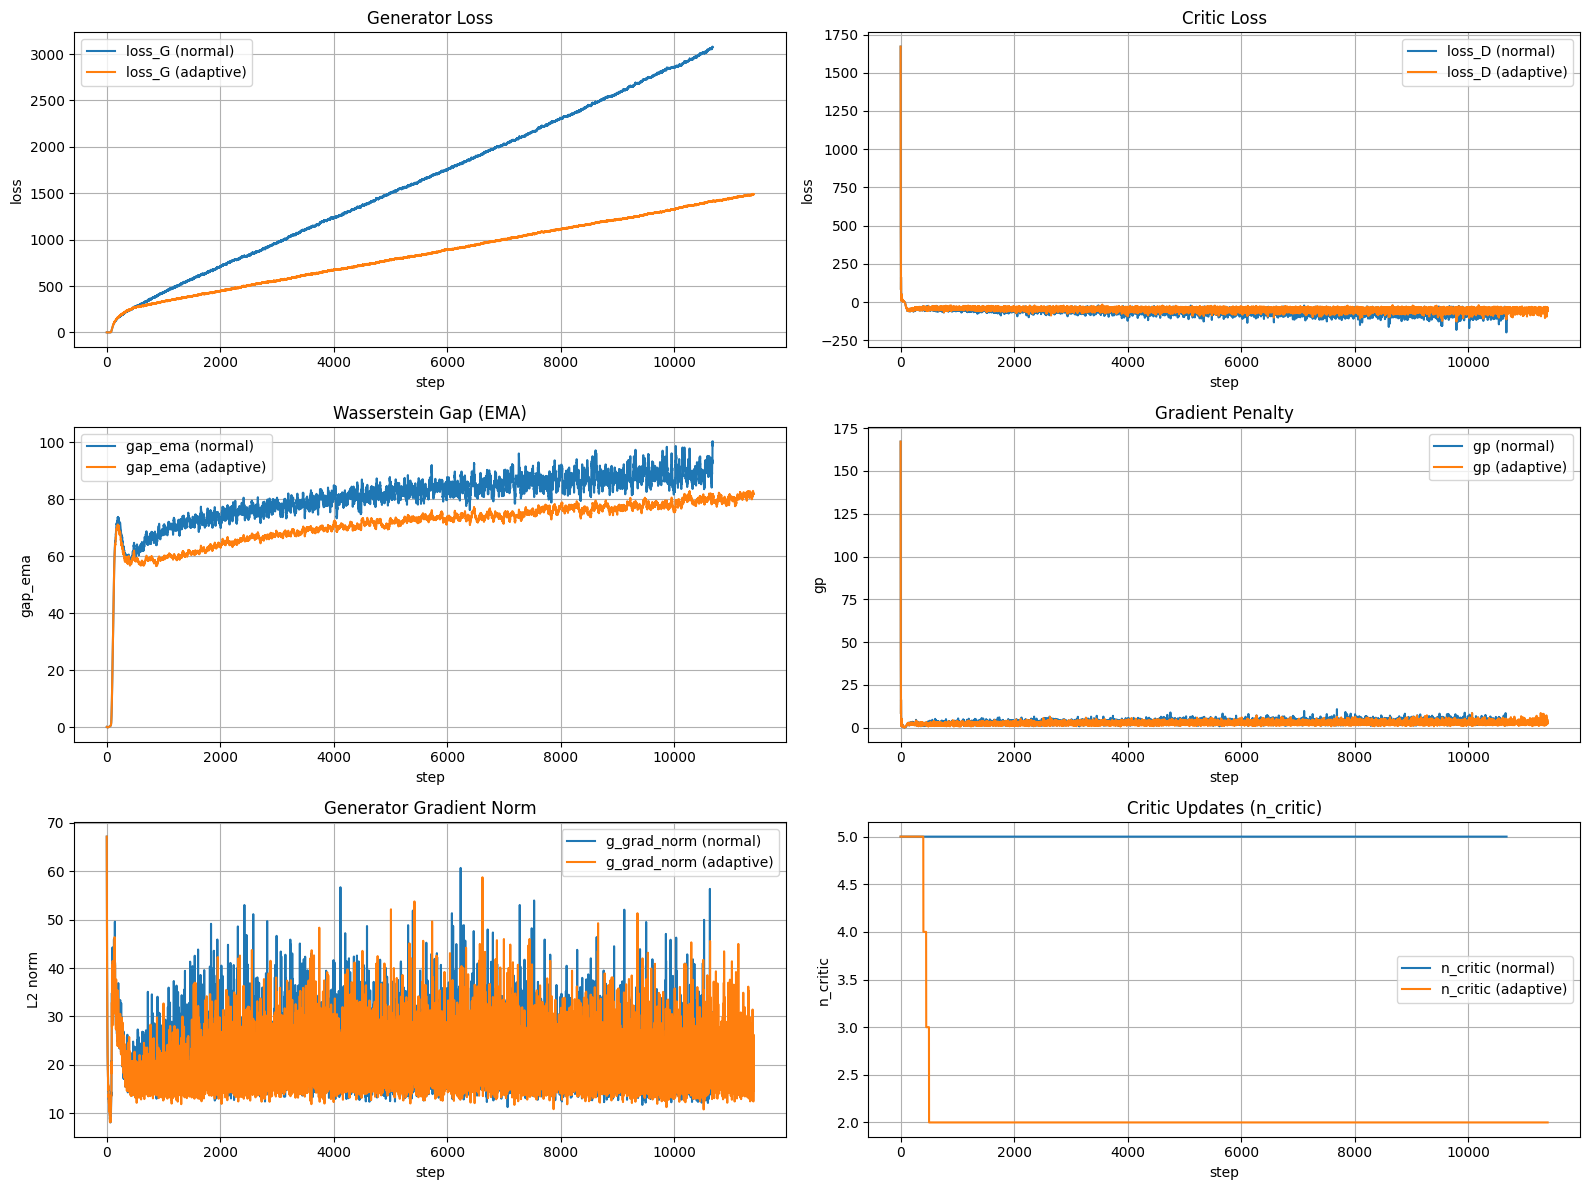

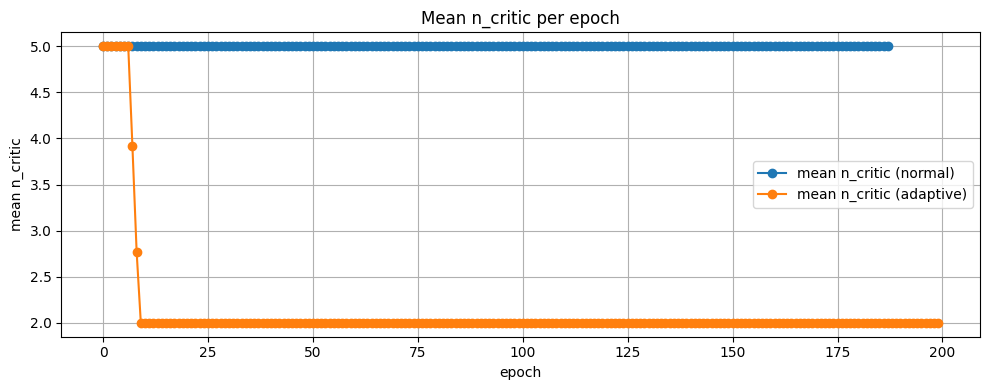

In [17]:
plot_compare(history_normal, history_adapt)